# Implementation Linear Bayesian Denoising Autoencoder on MNIST dataset


## Data loading and processing

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
!pip install -q tensorflow
%load_ext tensorboard

from skimage.metrics import structural_similarity as ssim

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

KeyboardInterrupt: 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [3]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

test_data_mnist = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=False,
                                  download=True, transform=transform)

test_data_fashion = datasets.FashionMNIST(root='data', train=False,
                                     download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 13503390.73it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 386392.82it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3659050.79it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3986300.22it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 26421880/26421880 [00:02<00:00, 9079014.12it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 179857.83it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3663968.04it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23675742.32it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
# how many samples per batch to load
batch_size = 64

test_loader_mnist = torch.utils.data.DataLoader(test_data_mnist, batch_size=batch_size, shuffle=False)
test_loader_fashion = torch.utils.data.DataLoader(test_data_fashion, batch_size=batch_size, shuffle=False)

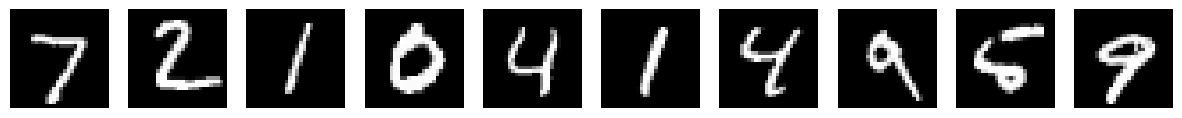

In [5]:
# Get a batch of training data
data_iter = iter(test_loader_mnist)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

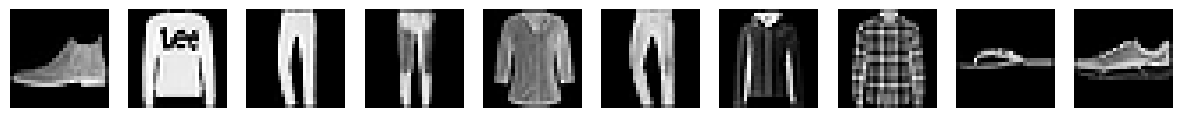

In [6]:
# Get a batch of training data
data_iter = iter(test_loader_fashion)
images, labels = next(data_iter)

# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 1.5))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].numpy().squeeze(), cmap='gray')
    ax.axis('off')

plt.show()

## Autoencoder Architectures

In [7]:
dropout_rate = 0.2

def MC_dropout(act_vec, p=0.5, mask=True):
  return F.dropout(act_vec, p=p, training=mask, inplace=False)

class LinearBDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 512)
        self.enc_fc2 = nn.Linear(512, 256)
        self.enc_fc3 = nn.Linear(256, 128)

        # Decoder layers
        self.dec_fc1 = nn.Linear(128, 256)
        self.dec_fc2 = nn.Linear(256, 512)
        self.dec_fc3 = nn.Linear(512, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var

class LinearDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder layers
        self.enc_fc1 = nn.Linear(28*28, 512)
        self.enc_fc2 = nn.Linear(512, 256)
        self.enc_fc3 = nn.Linear(256, 128)

        # Decoder layers
        self.dec_fc1 = nn.Linear(128, 256)
        self.dec_fc2 = nn.Linear(256, 512)
        self.dec_fc3 = nn.Linear(512, 28*28)

    def forward(self, x, dropout_p=dropout_rate, apply_dropout=True):
        # Encoder forward pass
        x = F.relu(self.enc_fc1(x))
        x = F.relu(self.enc_fc2(x))
        x = F.relu(self.enc_fc3(x))

        # Decoder forward pass with MC Dropout
        x = F.relu(self.dec_fc1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.dec_fc2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = torch.sigmoid(self.dec_fc3(x))
        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      return predictions, predictions_mean, predictions_var


class ConvolutionalBDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.3, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

class ConvolutionalDAEMNIST(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder layers
        self.conv1 = nn.Conv2d(1, 64, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # Increased number of output channels
        self.conv3 = nn.Conv2d(128, 256, 7)  # Increased number of output channels

        # Decoder layers
        self.deconv1 = nn.ConvTranspose2d(256, 128, 7)  # Increased number of input channels
        self.deconv2 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.deconv3 = nn.ConvTranspose2d(64, 1, 3, stride=2, padding=1, output_padding=1)  # Increased number of input channels
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, dropout_p=0.3, apply_dropout=True):
        # Encoder
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Decoder
        x = F.relu(self.deconv1(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = F.relu(self.deconv2(x))
        # x = MC_dropout(x, p=dropout_p, mask=apply_dropout)
        x = self.sigmoid(self.deconv3(x))

        return x

    def sample_predict(self, x, Nsamples):
      predictions = x.data.new(Nsamples, x.shape[0], 28*28)
      for i in range(Nsamples):
        y = self.forward(x)
        predictions[i] = y.view(-1, 28*28)

      predictions_mean = torch.mean(predictions, dim=0)
      predictions_var = torch.var(predictions, dim=0)

      predictions_mean = predictions_mean.view(-1, 1, 28, 28)
      predictions_var = predictions_var.view(-1, 1, 28, 28)

      return predictions, predictions_mean, predictions_var

In [8]:
def load_model(model_class, model_path, device='cpu'):
    model = model_class()
    checkpoint = torch.load(model_path, map_location=torch.device(device))

    # Check if the checkpoint contains 'model_state_dict'
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint

    model.load_state_dict(state_dict)
    model.eval()  # Set to evaluation mode
    return model

# Paths to the saved models
model_paths = {
    'linear_bdae_mnist': '/content/mnist_25_linear_bdae.pth',
    'linear_dae_mnist': '/content/mnist_25_linear_dae.pth',
    'convolutional_bdae_mnist': '/content/mnist_25_convolutional_bdae2.pth',
    'convolutional_dae_mnist': '/content/mnist_25_convolutional_dae2.pth',
}

# Dictionary to hold the loaded models
loaded_models = {}

# Load each model
loaded_models['linear_bdae_mnist'] = load_model(LinearBDAEMNIST, model_paths['linear_bdae_mnist'], device)
loaded_models['linear_dae_mnist'] = load_model(LinearDAEMNIST, model_paths['linear_bdae_mnist'], device)
loaded_models['convolutional_bdae_mnist'] = load_model(ConvolutionalBDAEMNIST, model_paths['convolutional_bdae_mnist'], device)
loaded_models['convolutional_dae_mnist'] = load_model(ConvolutionalDAEMNIST, model_paths['convolutional_dae_mnist'], device)

## Noise schemes

In [9]:
def add_gaussian_noise(images, noise_factor=0.5):
  corrupted_images = images + noise_factor * torch.randn(*images.shape)
  corrupted_images = np.clip(corrupted_images, 0., 1.)
  return corrupted_images

## Training Process

In [17]:
def linear_test(val_loader, net, criterion, Nsamples, noise_factor):
    total_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is set

    net.to(device)  # Move model to the appropriate device

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data
            images = images.view(images.size(0), -1)

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # Calculate SSIM
            ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)

            # keep track of loss
            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(val_loader.dataset)  # Compute average loss

    return avg_loss, ssim_score

In [20]:
def convolutional_test(val_loader, net, criterion, Nsamples, noise_factor):
    total_loss = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Ensure device is set

    net.to(device)  # Move model to the appropriate device

    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # iterate through batches
        for data in val_loader:
            # get the inputs; data is a list of [inputs, labels]
            images, _ = data

            corrupted_images = add_gaussian_noise(images, noise_factor=noise_factor)

            images = images.to(device)
            corrupted_images = corrupted_images.to(device)

            # forward pass
            predictions, predictions_mean, predictions_var = net.sample_predict(corrupted_images, Nsamples)
            loss = criterion(predictions_mean, images)

            # Calculate SSIM
            ssim_score = 0
            for img, output in zip(images, predictions_mean):
                img_np = img.cpu().detach().numpy().transpose(1, 2, 0)  # Assuming images are (batch_size, channels, height, width)
                output_np = output.cpu().detach().numpy().transpose(1, 2, 0)
                ssim_score += ssim(img_np, output_np, multichannel=True)

            ssim_score /= images.size(0)  # Average SSIM for the batch

            # keep track of loss
            total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(val_loader.dataset)  # Compute average loss

    return avg_loss, ssim_score

In [57]:
criterion = nn.MSELoss()

mse_linear_bdae_mnist, ssim_linear_bdae_mnist = linear_test(test_loader_mnist, loaded_models['linear_bdae_mnist'], criterion, 50, 0.5)
print(f'MSE of linear_bdae_mnist on MNIST test set: {mse_linear_bdae_mnist}')
print(f'SSIM of linear_bdae_mnist on MNIST test set: {ssim_linear_bdae_mnist}')

mse_linear_dae_mnist, ssim_linear_dae_mnist = linear_test(test_loader_mnist, loaded_models['linear_dae_mnist'], criterion, 50, 0.5)
print(f'MSE of linear_dae_mnist on MNIST test set: {mse_linear_dae_mnist}')
print(f'SSIM of linear_dae_mnist on MNIST test set: {ssim_linear_dae_mnist}')

mse_convolutional_bdae_mnist, ssim_convolutional_bdae_mnist = convolutional_test(test_loader_mnist, loaded_models['convolutional_bdae_mnist'], criterion, 50, 0.5)
print(f'MSE of convolutional_bdae_mnist on MNIST test set: {mse_convolutional_bdae_mnist}')
print(f'SSIM of convolutional_bdae_mnist on MNIST test set: {ssim_convolutional_bdae_mnist}')

mse_convolutional_dae_mnist, ssim_convolutional_dae_mnist = convolutional_test(test_loader_mnist, loaded_models['convolutional_dae_mnist'], criterion, 50, 0.5)
print(f'MSE of convolutional_dae_mnist on MNIST test set: {mse_convolutional_dae_mnist}')
print(f'SSIM of convolutional_dae_mnist on MNIST test set: {ssim_convolutional_dae_mnist}')

<ipython-input-17-18781758d03e>:25: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(predictions_mean.cpu().numpy(), images.cpu().numpy(), multichannel=True)


MSE of linear_bdae_mnist on MNIST test set: 0.014832813934981823
SSIM of linear_bdae_mnist on MNIST test set: 0.883945882320404
MSE of linear_dae_mnist on MNIST test set: 0.014717881336808205
SSIM of linear_dae_mnist on MNIST test set: 0.9021773934364319


<ipython-input-20-850a2b77cca9>:28: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score += ssim(img_np, output_np, multichannel=True)


MSE of convolutional_bdae_mnist on MNIST test set: 0.00981741424947977
SSIM of convolutional_bdae_mnist on MNIST test set: 0.9058450385928154
MSE of convolutional_dae_mnist on MNIST test set: 0.009381645987927914
SSIM of convolutional_dae_mnist on MNIST test set: 0.9053126573562622


### Training functions

### Training Procedure

## Visualizations

100%|██████████| 561753746/561753746 [00:11<00:00, 49049889.46it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


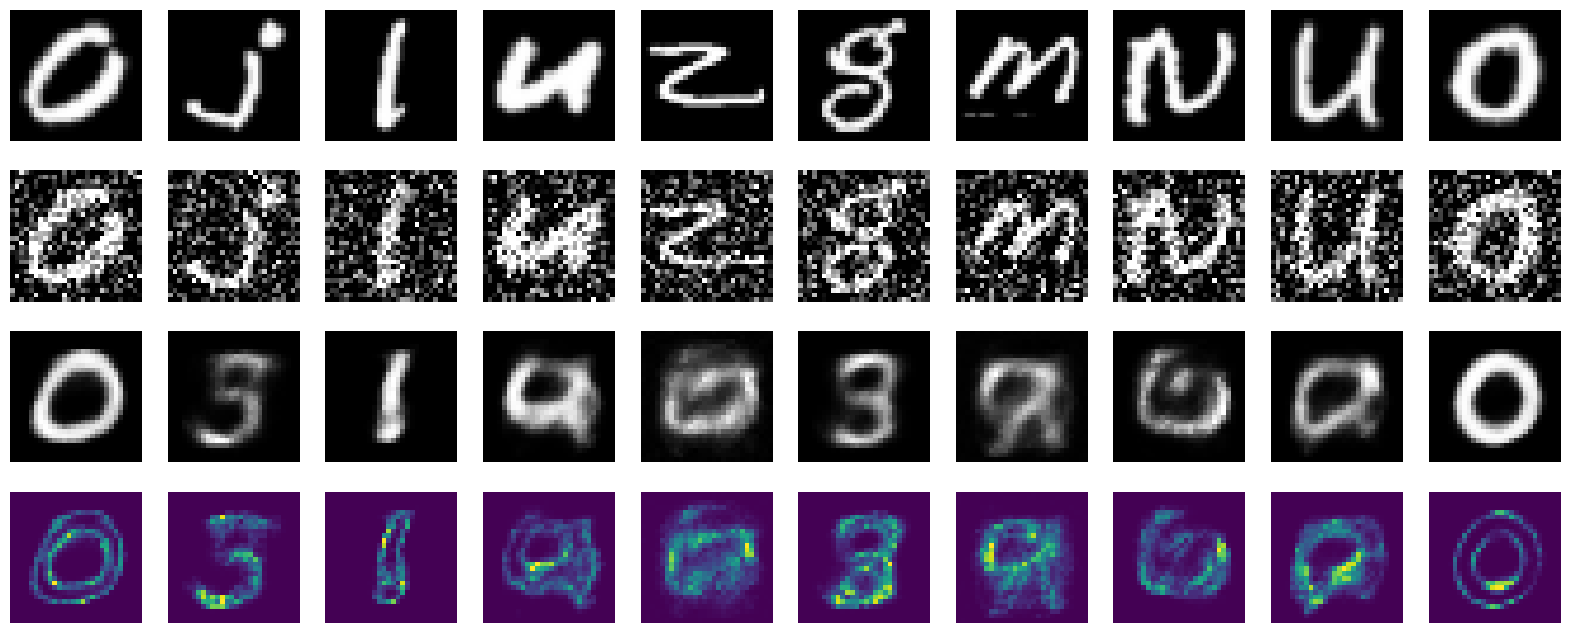

In [ ]:
# Download and load the EMNIST dataset
emnist_dataset = datasets.EMNIST(
                root='./data',
                download=True,
                split='letters',
                train=True,
                transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ])
            )
emnist_loader = torch.utils.data.DataLoader(emnist_dataset, batch_size=64, shuffle=True)

plot_mean_variance(emnist_loader)

## Evaluate on MNIST

### Preprocessing

#### Clean images

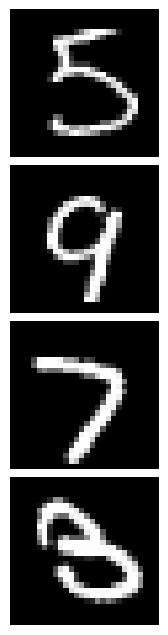

In [34]:
num_images = 4

def plot_images(images, num_images=4, space=0.05, cmap='gray', vmax=None):
    plt.figure(figsize=(2, 8))
    for i in range(4):
        plt.subplot(4, 1, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap=cmap, vmax=vmax)
        plt.axis('off')
    plt.subplots_adjust(wspace=space, hspace=space)
    plt.show()


# Initialize images
# Get a different set of 8 images and their labels from the test dataset
start_index = 15  # Change this to select a different starting point
mnist_images, _ = zip(*[(test_data_mnist[i][0], test_data_mnist[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(mnist_images, space=0.05, vmax=1)

#### Noisy images

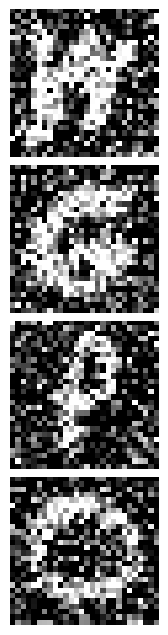

In [35]:
torch_images_mnist = torch.stack(images)

noisy_images_mnist = add_gaussian_noise(torch_images_mnist, 0.5)
plot_images(noisy_images_mnist, space=0.05, vmax=1)

### Linear

#### Linear DAE

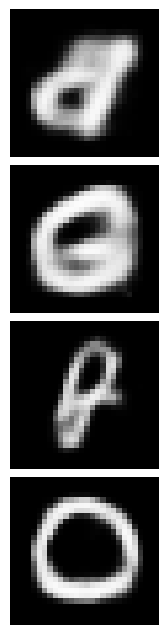

In [38]:
noisy_images_flattened_mnist = noisy_images_mnist.view(noisy_images_mnist.size(0), -1).to(device)

# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models['linear_dae_mnist'].sample_predict(noisy_images_flattened_mnist, 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Linear BDAE

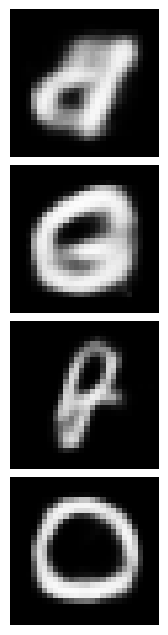

In [39]:
# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models['linear_bdae_mnist'].sample_predict(noisy_images_flattened_mnist, 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Linear BDAE

0.07225321


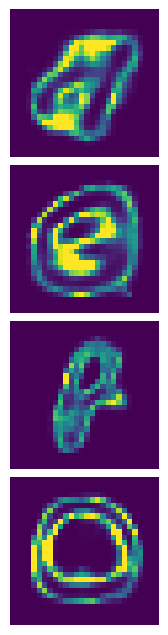

In [40]:
print(np.max(predictions_var_mnist.cpu().numpy()))
plot_images(predictions_var_mnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

### Convolutional

#### Convolutional DAE

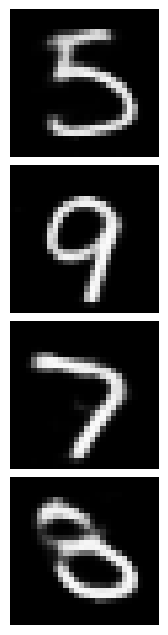

In [41]:
# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models['convolutional_dae_mnist'].sample_predict(noisy_images.to(device), 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Convolutional BDAE

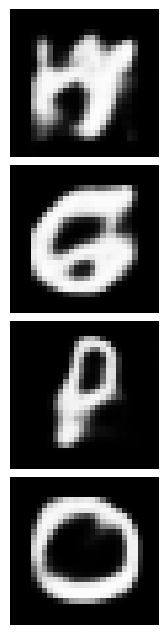

In [42]:
# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_mnist, predictions_var_mnist = loaded_models['convolutional_bdae_mnist'].sample_predict(noisy_images_mnist.to(device), 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

#### Model uncertainty Convolutional BDAE

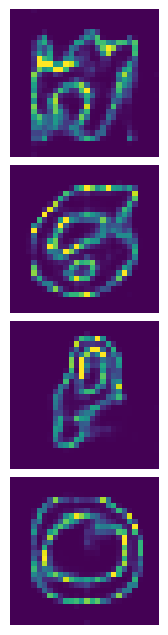

In [43]:
plot_images(predictions_var_mnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

## Evaluate on EMNIST

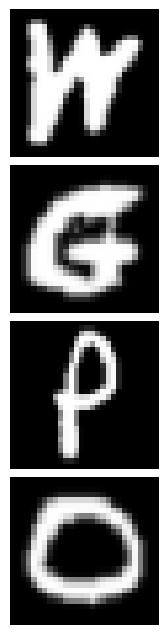

In [44]:
# Download and load the EMNIST dataset
emnist_dataset = datasets.EMNIST(
                root='./data',
                download=True,
                split='letters',
                train=True,
                transform=transforms.Compose([
                    lambda img: transforms.functional.rotate(img, -90),
                    lambda img: transforms.functional.hflip(img),
                    transforms.ToTensor()
                ])
            )
emnist_loader = torch.utils.data.DataLoader(emnist_dataset, batch_size=64, shuffle=True)

# Initialize images
# Get a different set of 8 images and their labels from the test dataset
start_index = 0  # Change this to select a different starting point
images_emnist, labels = zip(*[(emnist_dataset[i][0], emnist_dataset[i][1]) for i in range(start_index, start_index + 64)])

# Plot the images
plot_images(images_emnist, space=0.05, vmax=1)

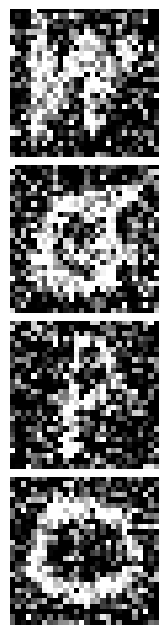

In [46]:
torch_images_emnist = torch.stack(images)

noisy_images_emnist = add_gaussian_noise(torch_images_emnist, 0.5)
plot_images(noisy_images_emnist, space=0.05, vmax=1)

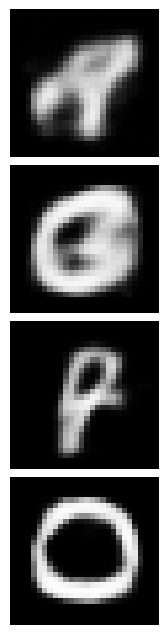

In [47]:
noisy_images_flattened_emnist = noisy_images_emnist.view(noisy_images_emnist.size(0), -1).to(device)

# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models['linear_dae_mnist'].sample_predict(noisy_images_flattened_emnist, 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

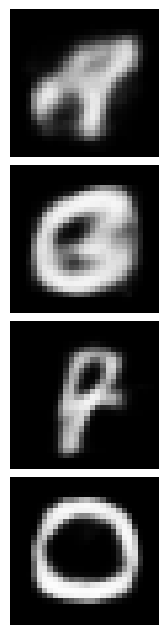

In [52]:
# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models['linear_bdae_mnist'].sample_predict(noisy_images_flattened_emnist, 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

0.093041226


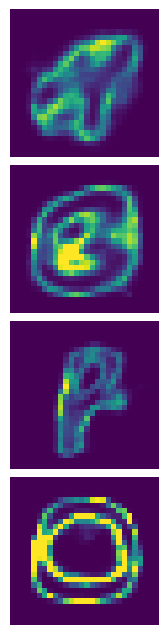

In [53]:
print(np.max(predictions_var_emnist.cpu().numpy()))
plot_images(predictions_var_emnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)

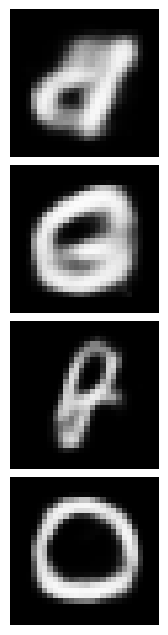

In [54]:
# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models['convolutional_dae_mnist'].sample_predict(noisy_images_emnist.to(device), 50)

plot_images(predictions_mean_mnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

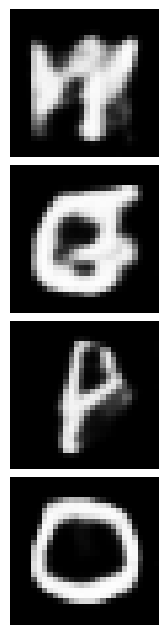

In [55]:
# bayesian_linear_model.eval()
with torch.no_grad():
    _, predictions_mean_emnist, predictions_var_emnist = loaded_models['convolutional_bdae_mnist'].sample_predict(noisy_images_emnist.to(device), 50)

plot_images(predictions_mean_emnist.view(-1,28,28).cpu(), space=0.05, vmax=1)

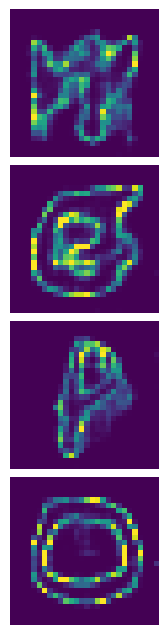

In [56]:
plot_images(predictions_var_emnist.view(-1,28,28).cpu(), space=0.05, cmap='viridis', vmax=0.03)